In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/etecsa/etecsa.csv")

In [3]:
# Asegurarnos de que las columnas tienen el tipo correcto
df['zone'] = df['zone'].astype(int)
df['time_start'] = df['time_start'].astype(int)
df['time_end'] = df['time_end'].astype(int)
df['user_index'] = df['user_index'].astype(int)
df['day'] = df['day'].astype(int)

In [4]:
# Un viaje se define por el `user_index` y el `day`
daily_trips = df.groupby('day')['user_index'].nunique()

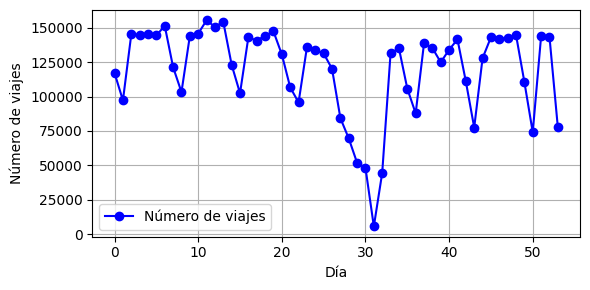

In [5]:
fig, ax = plt.subplots(figsize=(6, 3))

# Gráfica: Número de viajes por día
ax.plot(daily_trips.index, daily_trips.values, label='Número de viajes', color='blue', marker='o')
ax.set_ylabel('Número de viajes')
# ax.set_title('Número de viajes por día')
ax.legend()
ax.grid()

# Configuración general
plt.xlabel('Día')
plt.tight_layout()
plt.show()

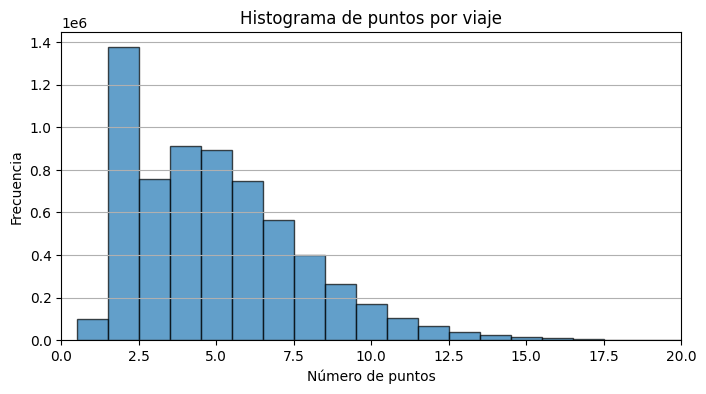

In [6]:
# Histograma de puntos por viaje:
# Un viaje es el conjunto de registros únicos para cada `user_index` y `day`
trip_points = df.groupby(['user_index', 'day']).size()

# Generar el histograma
plt.figure(figsize=(8, 4))
plt.hist(trip_points, bins=[i+0.5 for i in range(35)], edgecolor='k', alpha=0.7)
plt.title("Histograma de puntos por viaje")
plt.xlabel("Número de puntos")
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.xlim(0, 20)
plt.show()

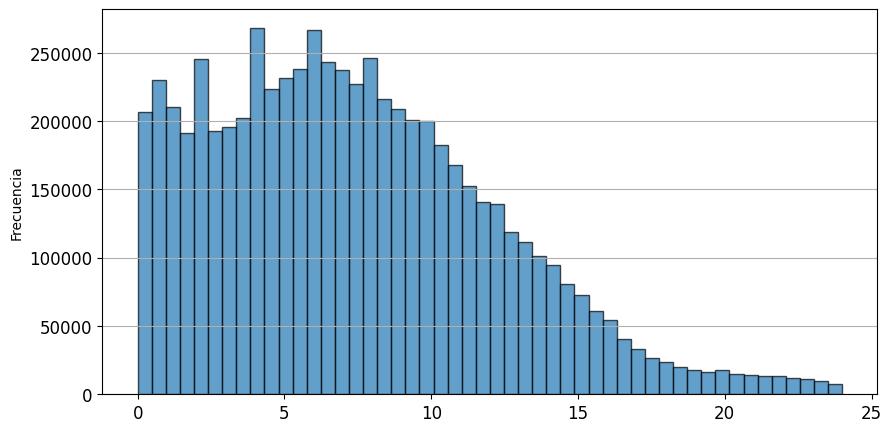

In [7]:
# Calcular directamente el tiempo de viaje como la diferencia entre el primer time_start y el último time_end
travel_times = df.groupby(['user_index', 'day']).agg(
    min_start=('time_start', 'min'),
    max_end=('time_end', 'max')
)

# Calcular la duración del viaje en segundos
travel_times['travel_time_seconds'] = travel_times['max_end'] - travel_times['min_start']

# Convertir a horas
travel_times['travel_time_hours'] = travel_times['travel_time_seconds'] / 3600

# Generar el histograma
plt.figure(figsize=(10, 5))
plt.hist(travel_times['travel_time_hours'], bins=50, edgecolor='k', alpha=0.7)
# plt.title("Histograma de tiempo de viaje (en horas)")
# plt.xlabel("Duración del viaje (horas)")
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.show()

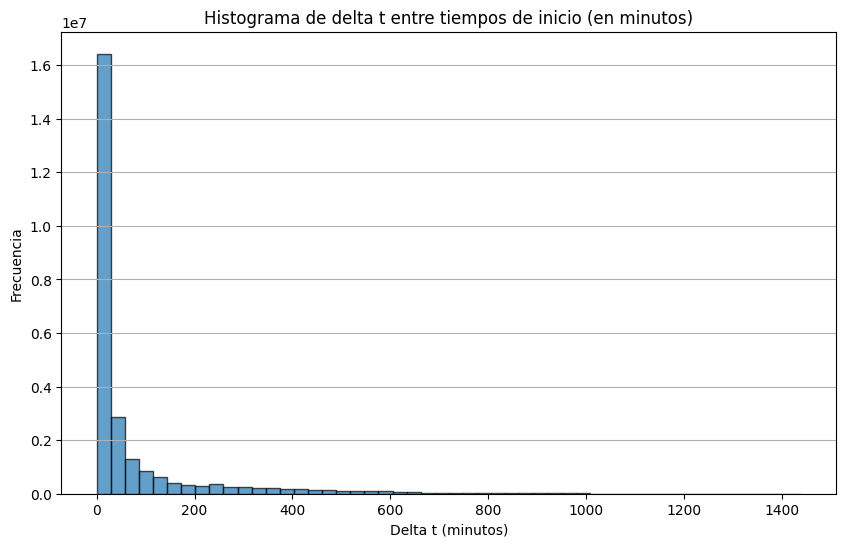

In [8]:
# Histograma de delta t entre tiempos de inicio (en minutos):
# Ordenamos por `user_index`, `day` y `time_start` para calcular diferencias consecutivas
data = df.sort_values(by=['user_index', 'day', 'time_start'])

# Calculamos la diferencia entre tiempos de inicio consecutivos
data['delta_t'] = data.groupby(['user_index', 'day'])['time_start'].diff()

# Filtrar valores positivos de delta_t (evitar NaN y errores de orden)
delta_t = data['delta_t'].dropna()

# Convertimos delta_t a minutos
delta_t_minutes = delta_t / 60  # Convertir de segundos a minutos

# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(delta_t_minutes, bins=50, edgecolor='k', alpha=0.7)
plt.title("Histograma de delta t entre tiempos de inicio (en minutos)")
plt.xlabel("Delta t (minutos)")
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.show()

In [9]:
# Calcular el delta_t entre time_start consecutivos
df['delta_t'] = df.groupby(['user_index', 'day'])['time_start'].diff()

# Calcular la diferencia máxima (max_delta_t) entre registros consecutivos por viaje
max_deltas = (
    df.groupby(['user_index', 'day'])['delta_t']
    .max()
    .reset_index()
    .rename(columns={'delta_t': 'max_delta_t'})
)

# Calcular la diferencia entre time_start y time_end para cada registro
df['start_end_diff'] = df['time_end'] - df['time_start']

# Calcular la diferencia máxima entre time_start y time_end por viaje
max_start_end_diff = (
    df.groupby(['user_index', 'day'])['start_end_diff']
    .max()
    .reset_index()
    .rename(columns={'start_end_diff': 'max_start_end_diff'})
)

# Unir los criterios en un solo DataFrame
criteria = pd.merge(max_deltas, max_start_end_diff, on=['user_index', 'day'])

# Filtrar viajes válidos (max_delta_t < 3600 y max_start_end_diff < 3600)
valid_trips = criteria[
    (criteria['max_delta_t'] < 3600) & (criteria['max_start_end_diff'] < 3600)
]

# Filtrar el DataFrame original para incluir solo los viajes válidos
filtered_trips = df.merge(valid_trips, on=['user_index', 'day'])

# Mostrar los resultados
print(f"Viajes válidos: {len(valid_trips)}")

Viajes válidos: 667794


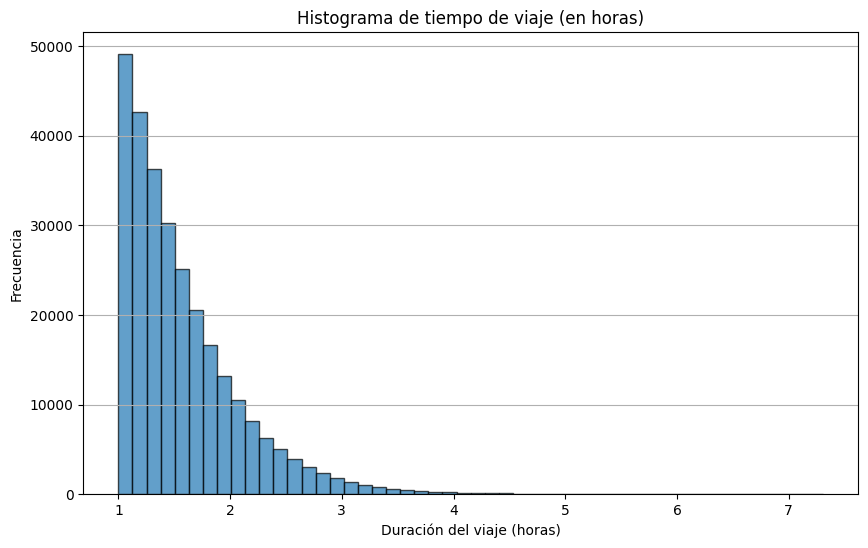

In [10]:
# Calcular directamente el tiempo de viaje como la diferencia entre el primer time_start y el último time_end
travel_times = filtered_trips.groupby(['user_index', 'day']).agg(
    min_start=('time_start', 'min'),
    max_end=('time_end', 'max'),
    points=('zone', 'count')
)

# Tomar viajes con al menos 10 registros
# travel_times = travel_times[travel_times['points'] >= 10]

# Calcular la duración del viaje en segundos
travel_times['travel_time_seconds'] = travel_times['max_end'] - travel_times['min_start']

# Tomar viajes de mas de una hora
travel_times = travel_times[travel_times['travel_time_seconds'] >= 3600]

# Convertir a horas
travel_times['travel_time_hours'] = travel_times['travel_time_seconds'] / 3600

# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(travel_times['travel_time_hours'], bins=50, edgecolor='k', alpha=0.7)
plt.title("Histograma de tiempo de viaje (en horas)")
plt.xlabel("Duración del viaje (horas)")
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.show()

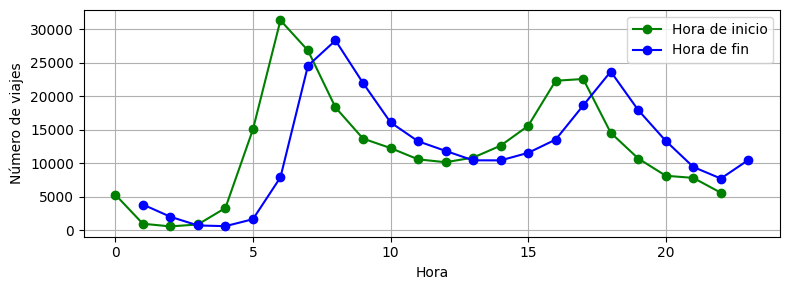

In [11]:
travel_times['min_start_hour'] = travel_times['min_start'] // 3600
travel_times['max_end_hour'] = travel_times['max_end'] // 3600

trip_inits = travel_times.groupby('min_start_hour').size()
trip_ends = travel_times.groupby('max_end_hour').size()

fig, ax = plt.subplots(figsize=(8, 3))

# Gráfica: Número de viajes por día
ax.plot(trip_inits.index, trip_inits.values, label='Hora de inicio', color='green', marker='o')
ax.plot(trip_ends.index, trip_ends.values, label='Hora de fin', color='blue', marker='o')
ax.set_ylabel('Número de viajes')
# ax.set_title('Horas de inicio y fin (agregado en todos los días)')
ax.legend()
ax.grid()

# Configuración general
plt.xlabel('Hora')
plt.tight_layout()
plt.show()

In [12]:
start_time_limit = 3600 * 6  # 6:00 AM
end_time_limit = 3600 * 18  # 6:00 PM

In [13]:
# Filtrar viajes que empiezan y terminan en el rango de tiempo
valid_travel_times = travel_times[
    (travel_times['min_start'] >= start_time_limit) & 
    (travel_times['max_end'] <= end_time_limit)
]

valid_travel_times.count()

min_start              171626
max_end                171626
points                 171626
travel_time_seconds    171626
travel_time_hours      171626
min_start_hour         171626
max_end_hour           171626
dtype: int64

In [14]:
# Frecuencias relativas en el conjunto original
original_zone_distribution = df['zone'].value_counts(normalize=True)

# Filtrar el subconjunto asociado a los tiempos calculados en travel_times
# Basado en min_start y max_end para cada viaje
subset_data = filtered_trips[
    filtered_trips.set_index(['user_index', 'day']).index.isin(valid_travel_times.index)
]

# Frecuencias relativas en el subconjunto
subset_zone_distribution = subset_data['zone'].value_counts(normalize=True)

# Crear un DataFrame para comparación
comparison_df = pd.DataFrame({
    'original': original_zone_distribution,
    'subset': subset_zone_distribution
}).fillna(1e-10)  # Reemplazar NaN con un valor muy pequeño

In [15]:
from scipy.spatial.distance import jensenshannon

# Convertir frecuencias relativas a arrays para comparación
original_probs = comparison_df['original']
subset_probs = comparison_df['subset']

# Calcular la divergencia de Jensen-Shannon
js_distance = jensenshannon(original_probs, subset_probs)
print(f"Divergencia de Jensen-Shannon: {js_distance:.4f}")


Divergencia de Jensen-Shannon: 0.0941


In [16]:
# Correlación de Pearson
pearson_corr = comparison_df['original'].corr(comparison_df['subset'], method='pearson')

# Correlación de Spearman
spearman_corr = comparison_df['original'].corr(comparison_df['subset'], method='spearman')

print(f"Correlación de Pearson: {pearson_corr:.4f}")
print(f"Correlación de Spearman: {spearman_corr:.4f}")

Correlación de Pearson: 0.9113
Correlación de Spearman: 0.9655


In [17]:
from scipy.stats import ks_2samp

# Aplicar el Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(comparison_df['original'], comparison_df['subset'])

# Mostrar resultados
print(f"KS Statistic: {ks_statistic}")
print(f"p-value: {p_value}")


KS Statistic: 0.07627118644067797
p-value: 0.8844665347689505


In [18]:
# Calcular la entropía cruzada
cross_entropy = -np.sum(
    comparison_df['original'] * np.log(comparison_df['subset'])
)

print(f"Cross-Entropy: {cross_entropy}")

Cross-Entropy: 4.4758102411234635


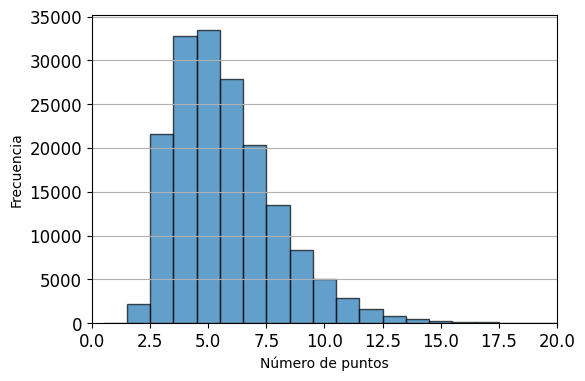

In [19]:
# Generar el histograma
plt.figure(figsize=(6, 4))
plt.hist(valid_travel_times['points'], bins=[i+0.5 for i in range(35)], edgecolor='k', alpha=0.7)
# plt.title("Histograma de puntos por viaje de 6am a 6pm")
plt.xlabel("Número de puntos")
plt.ylabel("Frecuencia")
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.grid(axis='y')
plt.xlim(0, 20)
plt.show()

C:\Users\alexs\AppData\Local\Temp\ipykernel_59428\3800867919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_travel_times['travel_time_seconds'] = valid_travel_times['max_end'] - valid_travel_times['min_start']
C:\Users\alexs\AppData\Local\Temp\ipykernel_59428\3800867919.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_travel_times['travel_time_hours'] = valid_travel_times['travel_time_seconds'] / 3600


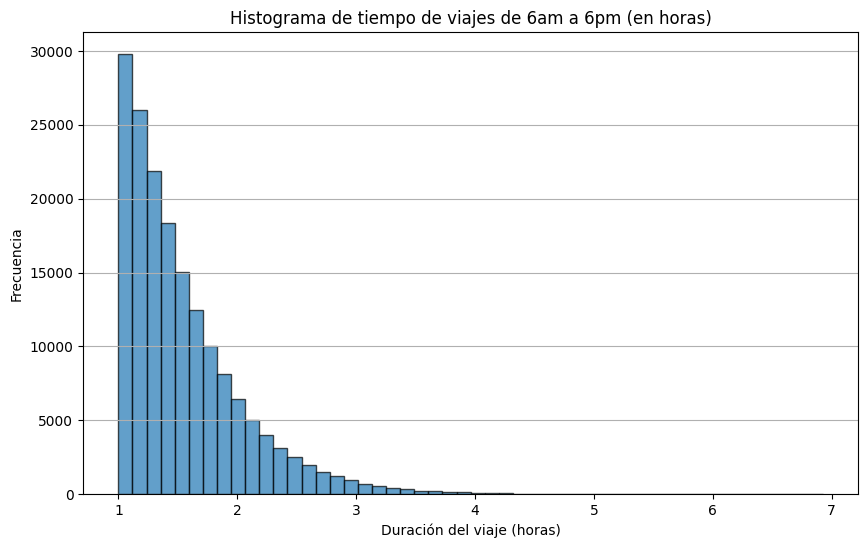

In [20]:
# Calcular la duración del viaje en segundos
valid_travel_times['travel_time_seconds'] = valid_travel_times['max_end'] - valid_travel_times['min_start']

# Convertir a horas
valid_travel_times['travel_time_hours'] = valid_travel_times['travel_time_seconds'] / 3600

# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(valid_travel_times['travel_time_hours'], bins=50, edgecolor='k', alpha=0.7)
plt.title("Histograma de tiempo de viajes de 6am a 6pm (en horas)")
plt.xlabel("Duración del viaje (horas)")
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.show()

In [21]:
# Calcular delta_t para registros consecutivos dentro de cada grupo
df['delta_t'] = df.groupby(['user_index', 'day'])['time_start'].diff()

# Crear un DataFrame con todas las diferencias de tiempo consecutivas
delta_t_consecutives = df[['user_index', 'day', 'delta_t']].dropna()  # Excluir NaN (primer registro de cada grupo)

# Combinar los resultados con `valid_travel_times` para asociar deltas con trayectorias
delta_t_with_valid_travel_times = delta_t_consecutives.merge(
    valid_travel_times, 
    on=['user_index', 'day'],
    how='inner'
)

# Convertir `delta_t` a minutos
delta_t_with_valid_travel_times['delta_t_minutes'] = delta_t_with_valid_travel_times['delta_t'] / 60  # Convertir a minutos
delta_t_minutes = delta_t_with_valid_travel_times['delta_t_minutes']


Estadísticas descriptivas de delta_t (en minutos):
- Media: 18.26 minutos
- Mediana: 12.12 minutos
- Desviación estándar: 16.67 minutos
- Percentil 25%: 4.32 minutos
- Percentil 50% (Mediana): 12.12 minutos
- Percentil 75%: 29.30 minutos


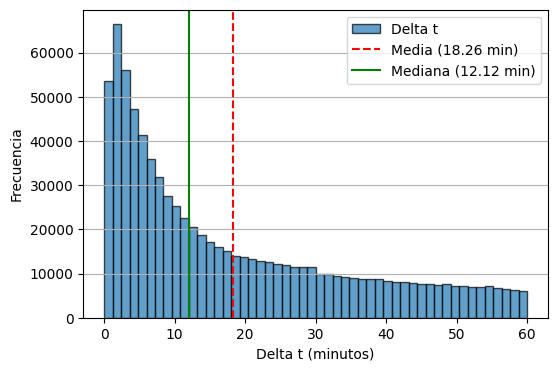

In [22]:
# Calcular estadísticas descriptivas
mean_delta = delta_t_minutes.mean()
median_delta = delta_t_minutes.median()
std_delta = delta_t_minutes.std()
percentiles_delta = delta_t_minutes.quantile([0.25, 0.5, 0.75])  # Percentiles 25%, 50%, 75%

# Imprimir estadísticas descriptivas
print("Estadísticas descriptivas de delta_t (en minutos):")
print(f"- Media: {mean_delta:.2f} minutos")
print(f"- Mediana: {median_delta:.2f} minutos")
print(f"- Desviación estándar: {std_delta:.2f} minutos")
print(f"- Percentil 25%: {percentiles_delta[0.25]:.2f} minutos")
print(f"- Percentil 50% (Mediana): {percentiles_delta[0.5]:.2f} minutos")
print(f"- Percentil 75%: {percentiles_delta[0.75]:.2f} minutos")

# Histograma con media y mediana
plt.figure(figsize=(6, 4))
plt.hist(delta_t_minutes, bins=50, edgecolor='k', alpha=0.7, label='Delta t')
plt.axvline(mean_delta, color='r', linestyle='--', label=f'Media ({mean_delta:.2f} min)')
plt.axvline(median_delta, color='g', linestyle='-', label=f'Mediana ({median_delta:.2f} min)')
# plt.title("Histograma de delta t entre tiempos de inicio (en minutos)")
plt.xlabel("Delta t (minutos)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(axis='y')
plt.show()

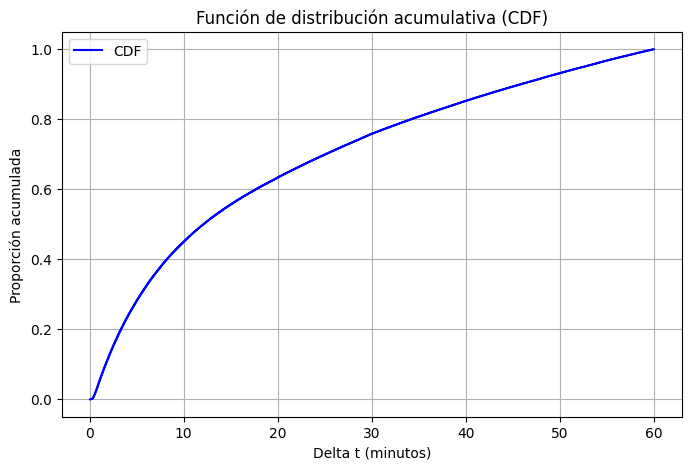

In [23]:
from statsmodels.distributions.empirical_distribution import ECDF

# Calcular la CDF
ecdf = ECDF(delta_t_minutes)

# Graficar la CDF
plt.figure(figsize=(8, 5))
plt.plot(ecdf.x, ecdf.y, label='CDF', color='blue')
plt.title('Función de distribución acumulativa (CDF)')
plt.xlabel('Delta t (minutos)')
plt.ylabel('Proporción acumulada')
plt.grid()
plt.legend()
plt.show()

C:\Users\alexs\AppData\Local\Temp\ipykernel_59428\2307548999.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(delta_t_minutes, shade=True, color="purple")


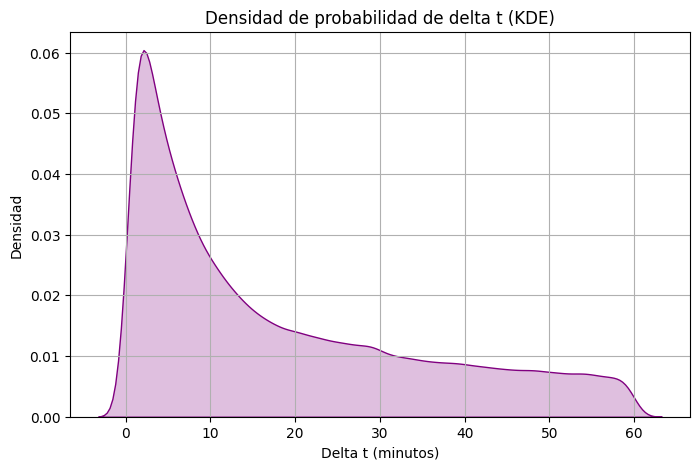

In [24]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.kdeplot(delta_t_minutes, shade=True, color="purple")
plt.title("Densidad de probabilidad de delta t (KDE)")
plt.xlabel("Delta t (minutos)")
plt.ylabel("Densidad")
plt.grid()
plt.show()


In [25]:
print(valid_travel_times)

                min_start  max_end  points  travel_time_seconds  \
user_index day                                                    
0          15       55128    60178       7                 5050   
           20       40485    46673      11                 6188   
           50       30921    36438       3                 5517   
1          28       36229    41242       5                 5013   
2          16       39089    45080       4                 5991   
...                   ...      ...     ...                  ...   
155417     11       53831    59705       4                 5874   
155467     11       26560    36354       7                 9794   
155503     11       50966    58127       7                 7161   
155505     11       26616    32191       6                 5575   
155543     11       29187    33583       4                 4396   

                travel_time_hours  min_start_hour  max_end_hour  
user_index day                                                

In [26]:
# Copiar los datos originales
processed_data = df.copy()

# Realizar la combinación con los datos de viajes válidos
processed_data = processed_data.merge(valid_travel_times, on=['user_index', 'day'], how='inner')

# Seleccionar solo las columnas necesarias
processed_data = processed_data[['zone', 'time_start', 'time_end', 'user_index', 'day']]

In [27]:
processed_data.to_csv("../data/etecsa/etecsa_processed.csv", index=False)

In [28]:
morning_data = processed_data.merge(valid_travel_times[valid_travel_times['max_end'] < 3600 * 12], on=['user_index', 'day'], how='inner')
afternoon_data = processed_data.merge(valid_travel_times[valid_travel_times['min_start'] > 3600 * 12], on=['user_index', 'day'], how='inner')

In [29]:
import geopandas as gpd
import json
from shapely.geometry import shape

def process_and_plot(datas, titles):
     # Cargar los datos GeoJSON una sola vez
    with open('./transport_zones.json', 'r') as fd:
        transp_zones_json = json.load(fd)

    # Convertir las zonas a un GeoDataFrame
    features = []
    for feature in transp_zones_json['features']:
        geom = shape(feature['geometry'])
        zone_id = feature['properties'].get('NO_DE_ZONA', 0)  # Reemplaza "NO_DE_ZONA" si es necesario
        features.append({'geometry': geom, 'NO_DE_ZONA': zone_id})
    base_gdf = gpd.GeoDataFrame(features)

    # Iterar sobre los datasets y los títulos
    fig, axes = plt.subplots(1, len(datas), figsize=(7 * len(datas), 6), sharey=True)
    if len(datas) == 1:  # En caso de un solo dataset, axes no será iterable
        axes = [axes]

    for i, (data, title) in enumerate(zip(datas, titles)):
        # Extraer la primera y última zona de cada grupo
        first_last_zones = data.groupby(['user_index', 'day']).agg(
            first_zone=('zone', 'first'), 
            last_zone=('zone', 'last')
        ).reset_index()

        # Contabilizar salidas (orígenes) y entradas (destinos)
        outgoing_counts = first_last_zones['first_zone'].value_counts()
        incoming_counts = first_last_zones['last_zone'].value_counts()

        # Calcular balance (entradas - salidas)
        all_zones = set(outgoing_counts.index).union(set(incoming_counts.index))
        balance_counts = {
            str(zone): outgoing_counts.get(zone, 0) - incoming_counts.get(zone, 0)
            for zone in all_zones
        }

        # Crear una copia del GeoDataFrame base para este dataset
        gdf = base_gdf.copy()

        # Mapear las densidades al GeoDataFrame
        gdf['density'] = gdf['NO_DE_ZONA'].map(balance_counts).fillna(0)

        # Aplicar transformación logarítmica con log-sign
        gdf['density_log'] = np.sign(gdf['density']) * np.log1p(np.abs(gdf['density']))

        # Graficar en el eje correspondiente
        gdf.plot(column='density_log', cmap='viridis', linewidth=0, ax=axes[i], edgecolor='black')
        axes[i].set_title(title)

    # Ajustar el espacio entre gráficos
    plt.tight_layout()
    plt.show()


In [30]:
process_and_plot([morning_data, afternoon_data], titles=['', '']
                #  titles=["Diferencia de Entradas y Salidas por Zona (Mañana)", "Diferencia de Entradas y Salidas por Zona (Tarde)"]
                 )

FileNotFoundError: [Errno 2] No such file or directory: './transport_zones.json'